In [ ]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Lambda, Input, Dense, \
                         Convolution2D, MaxPooling2D,Activation, \
                         Dropout, Flatten,  GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model, Sequential 
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from pathlib import Path
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils ,ds_to_ColorSpace

In [ ]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (256 ,256)
COLOR_SPACES = ["RGB"]
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

Found 19243 files belonging to 16 classes.
Found 3495 files belonging to 16 classes.


In [ ]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.05),
    ]
)

In [ ]:
class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

beige : 1.145
black : 0.974
blue : 1.091
brown : 1.144
cream : 2.004
crimson : 1.93
gold : 2.004
green : 1.33
grey : 0.876
navy-blue : 2.038
orange : 1.395
red : 1.156
silver : 1.273
titanium : 2.004
white : 0.209
yellow : 1.302


In [ ]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

train_ds = ds_to_ColorSpace(train_ds ,"RGB")
val_ds = ds_to_ColorSpace(val_ds ,"RGB")

# **Visualize Data**

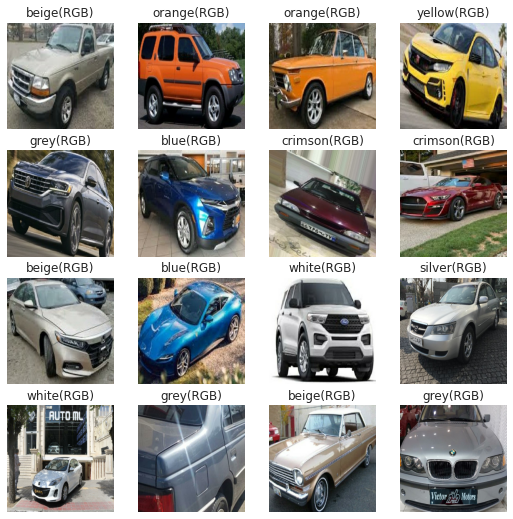

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      color_space = "RGB"
      image = tf.expand_dims(images[i] ,axis=0)
      #image = tf.cast(image * 255.0, tf.uint8)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , color_space )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

# **FineTunning Model**

In [ ]:
url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    hub.KerasLayer(url),
    Dense(1000),
    Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(input_shape=IMAGE_SIZE+(3,),
                         weights="imagenet", 
                         include_top=False,
                         include_preprocessing=True)
base_model.trainable = False

In [ ]:
len(base_model.layers)

383

In [ ]:
def ColorNet( training=False):
    inputs = keras.Input(shape=(IMAGE_SIZE+(3,)))
    inp = augmentation(inputs)
    inp = base_model(inp)
    inp = GlobalAveragePooling2D()(inp)
    inp = Dense(1000)(inp)
    if training:
      inp=Dropout(0.5)(inp)
    output = Dense(NUM_CLASSES, activation='softmax')(inp)
    return keras.Model(inputs=[inputs], outputs=[output])

In [ ]:
ColorNet(training=True).summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 efficientnetv2-b3 (Function  (None, 10, 10, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1000)              1537000   
                                                                 
 dropout_2 (Dropout)         (None, 1000)              0   

In [ ]:
model_utils = ModelUtils("RGB_v")

In [ ]:
run_index = 1
colorspace = "RGB_v"
base_model.trainable = False
model = ColorNet(training=True)
callbacks= model_utils.get_callbacks(early_stop=False ,tensorboard=False,run_index = run_index )
model = model_utils.make_or_restore_model(model)
n_epochs = 10
print("{}_Extracting Features : ".format(colorspace))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
        )   
model_utils.save_model_and_history(model ,run_index)

Creating a new model
RGB_v_Extracting Features : 
Epoch 1/10
301/301 [==============================] - ETA: 0s - loss: 2.1496 - accuracy: 0.3367 
Epoch 1: val_loss improved from inf to 1.88042, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_v/_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_v/_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_v/_1/assets


301/301 [==============================] - 3913s 13s/step - loss: 2.1496 - accuracy: 0.3367 - val_loss: 1.8804 - val_accuracy: 0.4735 - lr: 0.0010
Epoch 2/10
 34/301 [==>...........................] - ETA: 48:24 - loss: 1.6752 - accuracy: 0.5308

KeyboardInterrupt: ignored

In [ ]:
run_index = 1
fine_tune_at = 100 #int(len(base_model.layers)*(2/3))
INITIAL_EPOCH = 2
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
model = ColorNet(training=True)
model = model_utils.make_or_restore_model(model)
colorspace="RGB"
model = ModelUtils.get_compile_model(model, 1e-5)  
callbacks= model_utils.get_callbacks(lr_scheduler=False,run_index = run_index )
n_epochs2 = 20 + INITIAL_EPOCH
print("{} Finetunning Started : ".format(colorspace))
history = model.fit(train_ds,
              validation_data = val_ds,
              epochs = n_epochs2,
              callbacks = callbacks,
              class_weight = class_weights,
              initial_epoch = INITIAL_EPOCH)          

#model_utils.save_model_and_history(model ,run_index)

# **Simple ConvModel**

In [ ]:
Conv2D = partial(Convolution2D,kernel_size=(3, 3),strides=(2,2), activation='relu',padding='same')
Pool = partial(MaxPooling2D,pool_size=(3, 3) ,strides=(2,2))

In [ ]:
blocks = {
            "Conv":[       Conv2D(filters=32, kernel_size=(11, 11),input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
                          ,BatchNormalization() , Pool(),Conv2D(filters=64),BatchNormalization() , Pool()
                          ,Conv2D(filters=84 ,strides=(1,1)),Conv2D(filters=84 ,strides=(1,1)), Pool()
                   ],
            "Fc1":[
                          Dense(300, activation='relu'),Dense(200, activation='relu') 
                  ],
            "Fc2":[
                          Dense(300, activation='relu'),Dense(200, activation='relu') 
                  ],
            "Fc3":[
                          Dense(300, activation='relu'),Dense(200, activation='relu') 
                  ]
            
        }

In [ ]:
def BlockCNN(inputs):
    x = inputs
    for l in blocks["Conv"]:
        x = l(x)

    return x

In [ ]:
def BlockFc(inputs ,training=False):
    inp = Flatten()(inputs)
    inp1 ,inp2 ,inp3 = inp,inp,inp 
    for l1 ,l2 ,l3 in zip(blocks["Fc1"] ,blocks["Fc2"],blocks["Fc3"]):
        inp1 = l1(inp1)
        if training:
            inp1=Dropout(0.5)(inp1)
        inp2 = l2(inp2)
        if training:
            inp2=Dropout(0.5)(inp2)
        inp3 = l3(inp3)
        if training:
            inp3=Dropout(0.5)(inp3)
    inp = Concatenate()([inp1,inp2,inp3])
    inp = Dense(120 ,activation='relu')(inp)
    return Dense(units=16, activation='softmax')(inp)

In [ ]:
def ColorNet(training=False):
    input = keras.Input(shape= (IMAGE_SIZE+(3,)) )
    inputs = augmentation(input)
    z = BlockCNN(inputs)
    outputs = BlockFc(z,training)
    return keras.Model(inputs=[input], outputs=[outputs])

In [ ]:
model_utils = ModelUtils("RGB")

In [ ]:
run_index = 1
colorspace = "RGB"
model = ColorNet(training=True)
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model)
n_epochs = 50
print("{}: ".format(colorspace))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights,
          initial_epoch = 25
        )   
model_utils.save_model_and_history(model ,run_index)

# **Advanced ConvModel**

In [ ]:
Conv2D = partial(Convolution2D,kernel_size=(3, 3), strides=(1, 1), activation='relu',padding='same')
Pool = partial(MaxPooling2D,pool_size=(3, 3), strides=(2, 2))

In [ ]:
blocks ={
              "start_block":
                  [
                      Convolution2D(filters=48, kernel_size=(11, 11), strides=(4, 4),input_shape=(IMAGE_SIZE+(3,)), activation='relu')
                     , BatchNormalization() , Pool()
                  ]
              ,
              "top_before_concat":
                   [
                      Lambda(lambda x: x[:, :, :, :24]) , Conv2D(64) , BatchNormalization() , Pool() 
                   ]
                  ,
              "bot_before_concat":
                  [
                      Lambda(lambda x: x[:, :, :, 24:]), Conv2D(64) , BatchNormalization() , Pool() 
                  ]
                  ,
              "after_concat": Conv2D(192)
                  ,                
               "top_after_concat":
                  [
                      Lambda(lambda x: x[:, :, :, :96]), Conv2D(96), Conv2D(64), Pool()
                  ]
                  ,
                "bot_after_concat":
                  [
                       Lambda(lambda x: x[:, :, :, 96:]),  Conv2D(96),  Conv2D(64),  Pool()
                  ]
                  ,
            "Fc1":[
                          Dense(2000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(1000, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))
                  ],
            "Fc2":[
                          Dense(400, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(300, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)) 
                  ],
            "Fc3":[
                          Dense(400, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(300, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)) 
                  ]
          }

In [ ]:
def BlockCNN(inputs):
          conv_input =inputs
          for layer in blocks["start_block"] :
              conv_input = layer(conv_input)
          conv_input_top = conv_input
          conv_input_bot = conv_input

          for l_top ,l_bot in zip(blocks["top_before_concat"] , blocks["bot_before_concat"] ) :
              conv_input_top = l_top(conv_input_top)
              conv_input_bot = l_bot(conv_input_bot)
          concat = Concatenate()([conv_input_top ,conv_input_bot])
          concat = blocks["after_concat"](concat)
          conv_input_top ,conv_input_bot = concat ,concat

          for l_top ,l_bot in zip(blocks["top_after_concat"] , blocks["bot_after_concat"] ) :
              conv_input_top = l_top(conv_input_top)
              conv_input_bot = l_bot(conv_input_bot)

          return conv_input_top , conv_input_bot


In [ ]:
def BlockFC(inputs ,training=False):
    inp = Flatten()(inputs)
    #inp1 ,inp2 ,inp3 = inp,inp,inp 
    inp1 = inp
    for l1 in blocks["Fc1"]:
        inp1 = l1(inp1)
        if training:
            inp1=Dropout(0.5)(inp1)
        #inp2 = l2(inp2)
        #if training:
         #   inp2=Dropout(0.5)(inp2)
        #inp3 = l3(inp3)
        #if training:
         #   inp3=Dropout(0.5)(inp3)
    inp = inp1 #Concatenate()([inp1,inp2,inp3])
   # inp = Dense(600 ,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inp)#120
    return Dense(units=NUM_CLASSES, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inp)

In [ ]:
def ColorNet( training=False):
    inputs = keras.Input(shape=(IMAGE_SIZE+(3,)))
    inputs = augmentation(inputs)
    inp_1 ,inp_2=BlockCNN(inputs)
    inp = Concatenate()([inp_1 ,inp_2])
    output = inp
    output = BlockFC(output ,training=True) 
    return keras.Model(inputs=[inputs], outputs=[output])
ColorNet(training=True).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 54, 54, 48)   17472       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 54, 54, 48)  192         ['conv2d[1][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model_utils = ModelUtils("RGB")
run_index = 1
colorspace = "RGB"
model = ColorNet(training=True)
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model)
n_epochs = 50
print("{}: ".format(colorspace))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )   
model_utils.save_model_and_history(model ,run_index)

In [ ]:
model_path = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition',"Models","RGB",str(1))
model = keras.models.load_model(model_path)

eval_model = EvaluateModel(model ,val_ds, class_names,"RGB")

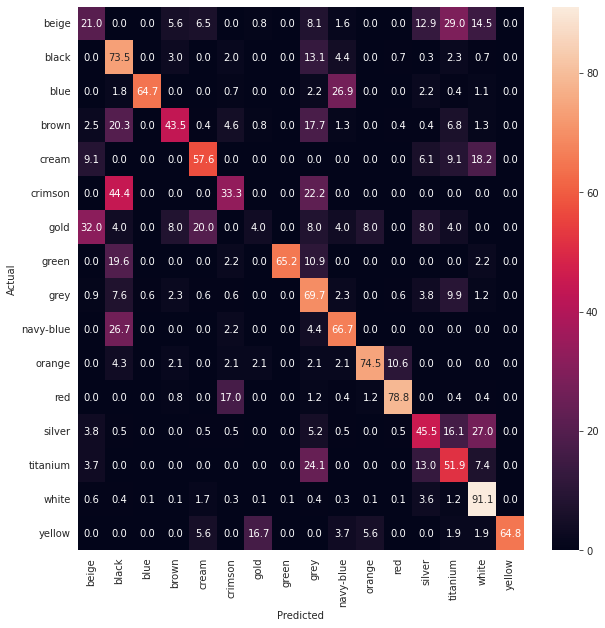

<Figure size 432x288 with 0 Axes>

In [ ]:
eval_model.plot_confusion()

In [ ]:
Conv2D = partial(Convolution2D,kernel_size=(3, 3), strides=(1, 1), activation='relu',padding='same')
Pool = partial(MaxPooling2D,pool_size=(3, 3), strides=(2, 2))

In [ ]:
blocks ={
              "start_block":
                  [
                      Convolution2D(filters=48, kernel_size=(11, 11), strides=(4, 4),input_shape=(IMAGE_SIZE+(3,)), activation='relu')
                     , BatchNormalization() , Pool()
                  ]
              ,
              "top_before_concat":
                   [
                      Lambda(lambda x: x[:, :, :, :24]) , Conv2D(64) , BatchNormalization() , Pool() 
                   ]
                  ,
              "bot_before_concat":
                  [
                      Lambda(lambda x: x[:, :, :, 24:]), Conv2D(64) , BatchNormalization() , Pool() 
                  ]
                  ,
              "after_concat": Conv2D(192)
                  ,                
               "top_after_concat":
                  [
                      Lambda(lambda x: x[:, :, :, :96]), Conv2D(96), Conv2D(64), Pool()
                  ]
                  ,
                "bot_after_concat":
                  [
                       Lambda(lambda x: x[:, :, :, 96:]),  Conv2D(96), Conv2D(64),  Pool()
                  ]
                  ,
            "Fc1":[
                          Dense(400 ,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(300,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01))
                  ],
            "Fc2":[
                          Dense(400,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(300,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)) 
                  ],
            "Fc3":[
                          Dense(400,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)),Dense(300,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01)) 
                  ]
          }

In [ ]:
def BlockCNN(inputs):
          conv_input =inputs
          for layer in blocks["start_block"] :
              conv_input = layer(conv_input)
          conv_input_top = conv_input
          conv_input_bot = conv_input

          for l_top ,l_bot in zip(blocks["top_before_concat"] , blocks["bot_before_concat"] ) :
              conv_input_top = l_top(conv_input_top)
              conv_input_bot = l_bot(conv_input_bot)
          concat = Concatenate()([conv_input_top ,conv_input_bot])
          concat = blocks["after_concat"](concat)
          conv_input_top ,conv_input_bot = concat ,concat

          for l_top ,l_bot in zip(blocks["top_after_concat"] , blocks["bot_after_concat"] ) :
              conv_input_top = l_top(conv_input_top)
              conv_input_bot = l_bot(conv_input_bot)

          return conv_input_top , conv_input_bot


In [ ]:
def BlockFC(inputs ,training=False):
    inp = Flatten()(inputs)
    inp1 ,inp2 ,inp3 = inp,inp,inp 
    inp1 = inp
    for l1 ,l2 ,l3 in zip(blocks["Fc1"],blocks["Fc2"],blocks["Fc3"]):
        inp1 = l1(inp1)
        if training:
            inp1=Dropout(0.5)(inp1)
        inp2 = l2(inp2)
        if training:
            inp2=Dropout(0.5)(inp2)
        inp3 = l3(inp3)
        if training:
            inp3=Dropout(0.5)(inp3)
    inp = Concatenate()([inp1,inp2,inp3])
    inp = Dense(120 ,activation = "relu",kernel_regularizer=tf.keras.regularizers.l2(0.01))(inp)#120
    return Dense(units=NUM_CLASSES, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.01))(inp)

In [ ]:
def ColorNet( training=False):
    inputs = keras.Input(shape=(IMAGE_SIZE+(3,)))
    inputs = augmentation(inputs)
    inp_1 ,inp_2=BlockCNN(inputs)
    inp = Concatenate()([inp_1 ,inp_2])
    output = inp
    output = BlockFC(output ,training=True) 
    return keras.Model(inputs=[inputs], outputs=[output])
ColorNet(training=True).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 62, 62, 48)   17472       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 62, 62, 48)  192         ['conv2d[1][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model_utils = ModelUtils("RGB_2")
run_index = 1
colorspace = "RGB_2"
model = ColorNet(training=True)
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model)
n_epochs = 50
print("{}: ".format(colorspace))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )   

Creating a new model
RGB_2: 
Epoch 1/50
602/602 [==============================] - ETA: 0s - loss: 15.6086 - accuracy: 0.3373
Epoch 1: val_loss improved from inf to 5.02295, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_2/_1
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_2/_1/assets
602/602 [==============================] - 1569s 3s/step - loss: 15.6086 - accuracy: 0.3373 - val_loss: 5.0229 - val_accuracy: 0.4887 - lr: 0.0100
Epoch 2/50
602/602 [==============================] - ETA: 0s - loss: 2.9342 - accuracy: 0.5065
Epoch 2: val_loss improved from 5.02295 to 2.16547, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_2/_2
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_2/_2/assets
602/602 [==============================] - 904s 1s/step - loss: 2.9342 - accuracy: 0.5065 - val_loss: 2.1655 - 

In [ ]:
model_utils.save_model_and_history(model ,run_index)